In [1]:
%pylab inline
import circlesquare
import pandas as pd
import scipy.stats as stats

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Simulate the two actors in competition

In [3]:
def simulate(learning_effort=.1, rounds=1000, dt=1):
    product = circlesquare.CircleSquare()
    product.make_pts(10000)

    defense = product.new_interface('Defense')
    defense.make_circles(max_area=.01)

    offense = product.new_interface('Offense')
    offense.make_circles(max_area=.01)
    
    
    output = []
    stockpile = offense.seek(0) #initialize by conducting zero rounds of searching.

    for i in range(0,rounds,dt):
        output.append({'round':i,
                       'defensive profile':np.sum(defense.circles.area),
                       'offensive profile':np.sum(offense.circles.area),
                       'stockpile':stockpile.sum(),
                       'remaining':product.count_pts(),
                       'correlation':defense.get_correlation(offense)[0]})

        if stats.binom(1, learning_effort).rvs():
            defense.learn(offense, frac=.35, mean_weight=.35)
        else:
            defense.harden(dt)

        defense.update()
        offense.update()


        stockpile = stockpile | offense.seek(dt)
        stockpile = stockpile.loc[product.pts.index]

    df = pd.DataFrame(output).set_index('round')
    df["vuln-days"] = df['stockpile'].cumsum()
    return df

simulate(learning_effort=.5, rounds=10, dt=1)

,correlation,defensive profile,offensive profile,remaining,stockpile,vuln-days
round,,,,,,
0,0.011604,49.865344,49.882464,10000,0,0
1,0.012350,49.655466,49.737520,9968,48,48
2,0.013304,49.325898,49.490559,9914,92,140
3,0.013002,49.094835,49.283232,9876,144,284
4,0.076060,51.024632,49.283232,9876,197,481
5,0.131182,52.725871,49.283232,9876,214,695
6,0.131621,52.326237,48.995959,9819,240,935
7,0.131825,51.932685,48.715046,9763,298,1233
8,0.184797,53.477622,48.715046,9763,358,1591


In [4]:
from multiprocessing import Pool

p = Pool(3)
dfs = p.map(simulate, np.arange(0, .25, .025))

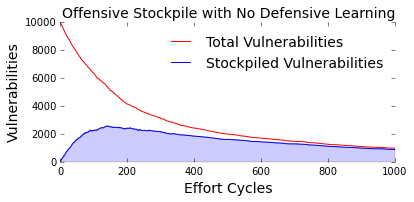

In [5]:
df = dfs[0]

plt.figure(figsize=(6,2.5))
plt.plot(df.index, df['remaining'], 'r', label='Total Vulnerabilities')
plt.plot(df.index, df['stockpile'], 'b', label='Stockpiled Vulnerabilities')
plt.fill_between(df.index, df['stockpile'], alpha=.2, label='Vulnerability-Days')
plt.ylabel('Vulnerabilities', fontsize=14)
plt.xlabel('Effort Cycles', fontsize=14)
plt.box('off')
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.title('Offensive Stockpile with No Defensive Learning', fontsize=14);

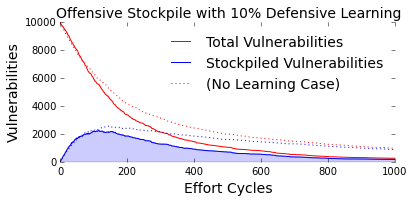

In [6]:
#find the run that had the minimum final value for vulnerability-days
vds = [df['vuln-days'].iloc[-1] for df in dfs]
df = dfs[vds.index(min(vds))]

#plot the curve with the minimum final vulnerability-days
plt.figure(figsize=(6,2.5))
plt.plot(df.index, df['remaining'], 'r', label='Total Vulnerabilities')
plt.plot(df.index, df['stockpile'], 'b', label='Stockpiled Vulnerabilities')
plt.fill_between(df.index, df['stockpile'], alpha=.2, label='Vulnerability-Days')

#also plot the no-learning case
df0 = dfs[0]
plt.plot(df0.index, df0['remaining'], 'r:', label='(No Learning Case)')
plt.plot(df0.index, df0['stockpile'], 'b:',)

#format
plt.ylabel('Vulnerabilities', fontsize=14)
plt.xlabel('Effort Cycles', fontsize=14)
plt.box('off')
plt.legend(loc='upper right', frameon=False, fontsize=14)
plt.title('Offensive Stockpile with 10% Defensive Learning', fontsize=14);


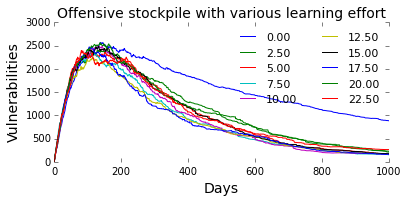

In [7]:
plt.figure(figsize=(6,2.5))

for df, frac in zip(dfs, np.arange(0, .25, .025)):
    plt.plot(df.index, df['stockpile'], label='%.02f'%(frac*100))


plt.ylabel('Vulnerabilities', fontsize=14)
plt.xlabel('Days', fontsize=14)
plt.box('off')
plt.legend(loc='upper right', frameon=False, ncol=2, fontsize=11)
plt.title('Offensive stockpile with various learning effort', fontsize=14); 

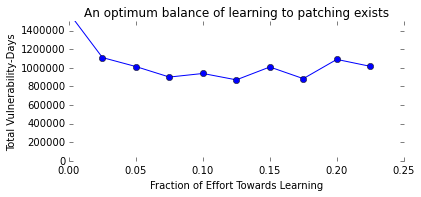

In [8]:
plt.figure(figsize=(6,2.5))
vds = [df['vuln-days'].iloc[-1] for df in dfs]
plt.plot(np.arange(0, .25, .025), vds, 'bo-')
plt.ylim(0, 1500000)
plt.ylabel('Total Vulnerability-Days')
plt.xlabel('Fraction of Effort Towards Learning')
plt.title('An optimum balance of learning to patching exists')
plt.box('off')